In [1]:
import dgl
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import random_split
import dgl.data
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import numpy as np
import dgl.data
import pickle
import glob
import networkx as nx
import matplotlib
import numpy
import dgl.nn.pytorch as dglnn

device = torch.device("cuda")

In [2]:

# Load data
graphs = dgl.load_graphs('./cybercrime_first_homographs.dgl')


for i, s in tqdm(enumerate(graphs[0])):
    graphs[0][i] = dgl.add_self_loop(graphs[0][i])
    graphs[0][i] = graphs[0][i].to('cuda')
    




5573it [00:04, 1160.07it/s]


In [3]:

dataset = tuple(zip(graphs[0], graphs[1]['glabels'].argmax(1)))

# dataset = dataset[:1659+1700]

In [7]:
from dgl.nn import GraphConv, HeteroGraphConv, SAGEConv
import torch.nn as nn
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchmetrics import F1Score, Accuracy, Precision, Recall
import sys

class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, n_classes, n_layer):
        super().__init__()

        self.n_layer = n_layer

        self.gcnlayer = torch.nn.ModuleList()

        # Input Layer
        self.gcnlayer.append(SAGEConv(in_feats, hid_feats, 'pool'))
        # Hidden Layer
        for layer in range(n_layer-2):
            self.gcnlayer.append(SAGEConv(hid_feats, hid_feats, 'pool'))
        # Output Layer
        self.gcnlayer.append(SAGEConv(hid_feats, out_feats, 'pool'))

        self.classify = nn.Linear(out_feats, n_classes)

    def forward(self, graph, feat, eweight=None):
        h = feat
        
        for i, layer in enumerate(self.gcnlayer):
            if i < self.n_layer-1:
                h = F.relu(layer(graph, h))
            else:
                h = layer(graph, h)

        graph.ndata['h'] = h

        hg = dgl.readout_nodes(graph, 'h', op='mean')

        self.graph_representation = hg

        return self.classify(hg)

    def graph_representation(self):
        return self.graph_representation

def pred(model, average, dataloader, debug=False):

    f1_score = F1Score(num_classes=5, average=average)
    precision_score = Precision(num_classes=5, average=average)
    recall_score = Recall(num_classes=5, average=average)
    accuracy_score = Accuracy(num_classes=5, average=average)

    y_pred = torch.tensor([], dtype=torch.int32).to('cuda')
    y_label = torch.tensor([], dtype=torch.int32).to('cuda')

    for batched_graph, labels in dataloader:
        feat = batched_graph.ndata['feature'].float()
        pred = model(batched_graph, feat)
        y_pred = torch.cat((y_pred, pred), 0)
        y_label = torch.cat((y_label, labels.to(device)), 0)

    acc = accuracy_score(y_pred.cpu().argmax(1), y_label.cpu())
    f1 =  f1_score(y_pred.cpu().argmax(1), y_label.cpu())
    pr = precision_score(y_pred.cpu().argmax(1), y_label.cpu())
    re = recall_score(y_pred.cpu().argmax(1), y_label.cpu())

    if debug:
        print('Test accuracy:', acc)

        print('Precision: {}, Recall: {}, F1-score: {}'.format(pr, re, f1))
    return y_label, y_pred, acc, pr, re, f1

def train(model, n_epoch, optimizer, dataloader, weights, test_dataloader=None, h=None, o=None, nl=None, batch_size=None):
    f1_score = F1Score(num_classes=5, average='weighted')
    precision_score = Precision(num_classes=5, average='weighted')
    recall_score = Recall(num_classes=5, average='weighted')
    accuracy_score = Accuracy(num_classes=5, average='weighted')
    for epoch in tqdm(range(n_epoch), desc="{} {} {} {}".format(h, o, nl, batch_size)):
        for batched_graph, labels in dataloader:
            model.train()
            feat = batched_graph.ndata['feature'].float()
            predd = model(batched_graph, feat)
            loss = F.cross_entropy(predd, labels.to(device), weight=weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        _, _, acc, pr, re, f1 = pred(model, 'weighted', test_dataloader)
        # if f1 > 0.5:
        print('Test accuracy:', acc)

        print('Precision: {}, Recall: {}, F1-score: {}'.format(pr, re, f1))

            # torch.save(model, './homograph_first_all/{}_{}_{}_{}_{:.4f}_{:.4f}_{:.4f}_{:.4f}.pt'.format(h, o, nl, batch_size, acc, f1, pr, re))



In [5]:
from sklearn.model_selection import train_test_split

# Spliting Datset into training and testing

num_train = int(len(dataset)*0.8)
train_dataset, val_dataset = random_split(dataset, (num_train, len(dataset)-num_train))


# Obtaining weight of training datset and apply weightedrandomsampler
labels = [l for _, l in train_dataset]

target_list = torch.tensor([0, 1, 2, 3, 4])

class_count = [0, 0, 0, 0, 0]

# labels = [l for _, l in train_dataset]

# target_list = torch.tensor([0, 1])

# class_count = [0, 0]

# Get the # of each class
for index, data in enumerate(train_dataset):
    class_count[data[1]] += 1
    
class_weights = torch.Tensor([len(train_dataset) / class_count[i] for i in range(len(class_count))]).to('cuda')

weights = [class_weights[labels[i]] for i in range(len(train_dataset))]


weighted_sampler = WeightedRandomSampler(
    weights=torch.FloatTensor(weights),
    num_samples=len(train_dataset),
)

In [ ]:
import warnings
import itertools
warnings.simplefilter("ignore", UserWarning)

hid_feats = [64]
out_feats = [64]
n_layers = [2]
batch_sizes = [128]

# hid_feats = [64]
# out_feats = [64]
# n_layers =  [6]
# batch_sizes = [128]

all_comb = list(itertools.product(hid_feats, out_feats, n_layers, batch_sizes))

for hid_feat, out_feat, n_layer, batch_size in all_comb:
    model = GCN(13, hid_feat, out_feat, 5, n_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_dataloader = GraphDataLoader(train_dataset, sampler=weighted_sampler, batch_size=batch_size, pin_memory=True)

    test_dataloader = GraphDataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

    train(model, 30, optimizer, train_dataloader, class_weights, test_dataloader, hid_feat, out_feat, n_layer, batch_size)



In [74]:
model = torch.load("./64_16_3_1_0.8475_0.8451_0.8492_0.8475.pt")

Test accuracy: tensor(0.8484)
Precision: 0.8476806879043579, Recall: 0.8484304547309875, F1-score: 0.845622181892395


Text(141.16666666666669, 0.5, 'Actually Class\n')

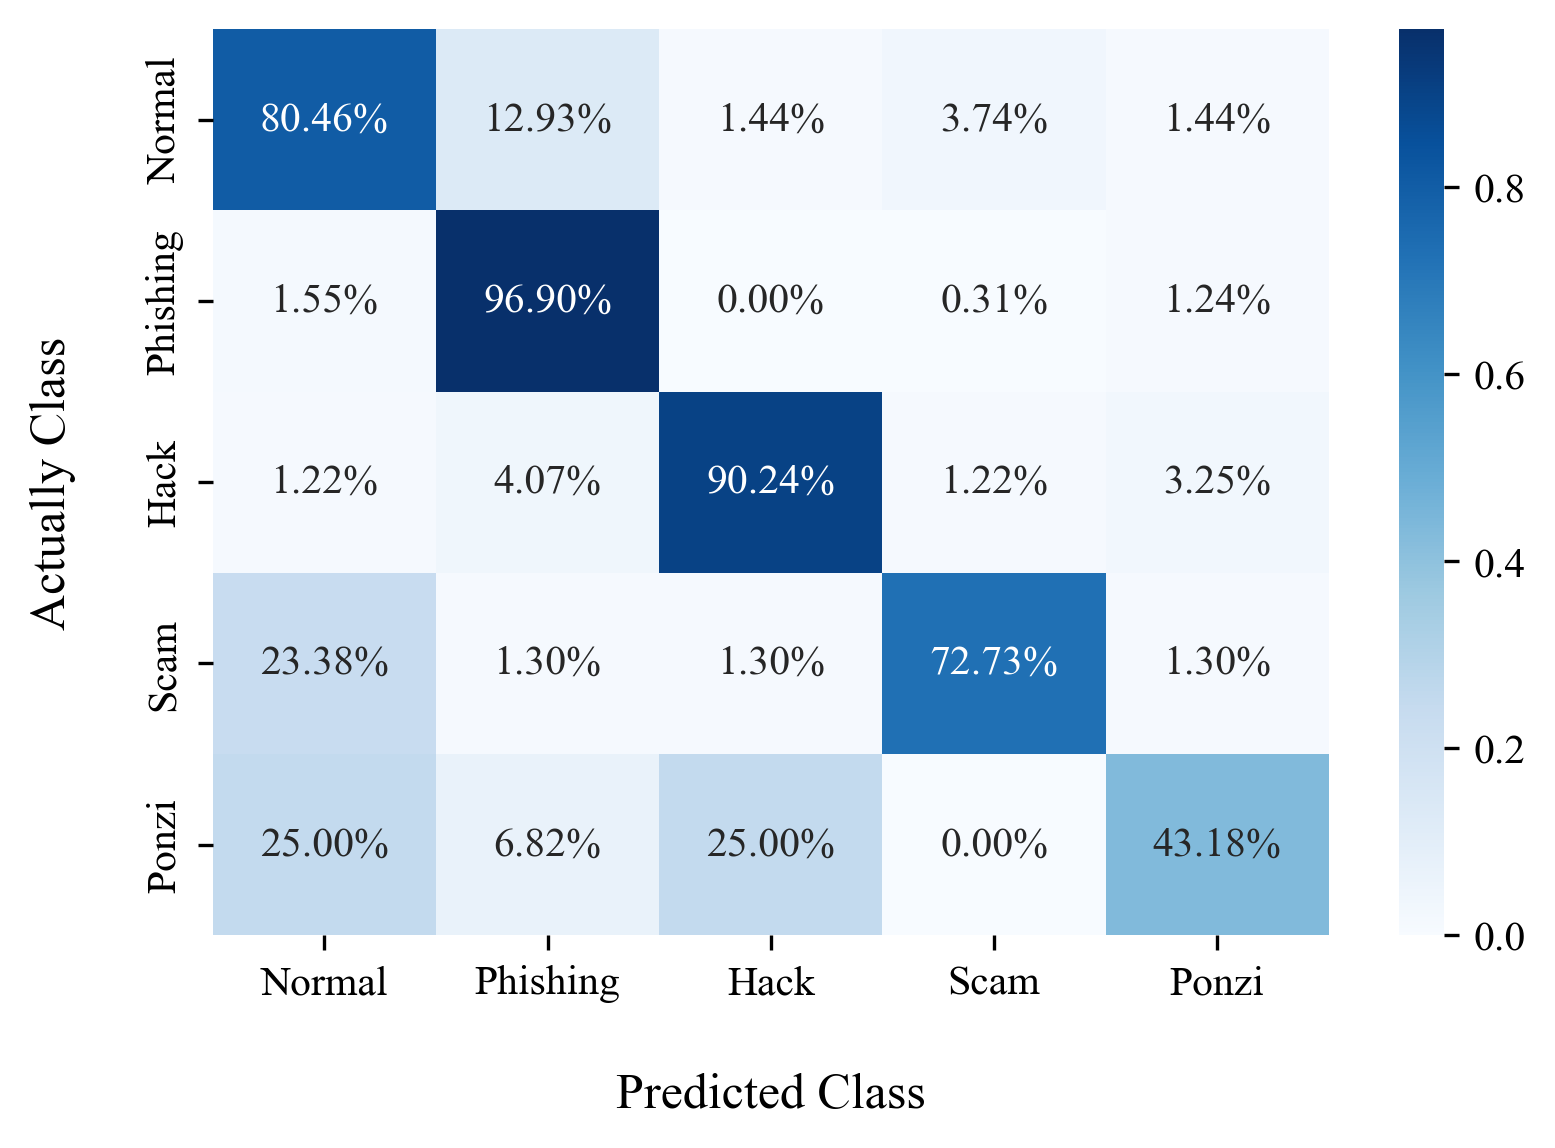

In [107]:
test_dataloader = GraphDataLoader(val_dataset, batch_size=128, pin_memory=True)
y_label, y_pred, _ ,_, _,_  = pred(model, 'weighted', test_dataloader, True)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

confmat = ConfusionMatrix(num_classes=5)
cf_matrix = confmat(y_pred.cpu(), y_label.cpu())
cf_matrix = cf_matrix.numpy()


cfm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

label_name = ["Normal", "Phishing", "Hack", "Scam", "Ponzi"]

plt.rcParams['font.family'] = "Times New Roman"

ax = sns.heatmap(cfm, annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=label_name, yticklabels=label_name)
ax.set_xlabel("\nPredicted Class", fontsize=12)
ax.set_ylabel("Actually Class\n", fontsize=12)
# ax.set_title("Confusion Matrix of \nCybercriminal Account Classification\n\n")


In [102]:
len(dataset)
cl = [0, 0, 0, 0, 0]
for i in range(len(dataset)):
    _, l = dataset[i]
    cl[l.cpu()] += 1
    

In [103]:
cl

[1699, 1660, 1189, 825, 200]

In [100]:
from dgl.nn import GNNExplainer

explainer = GNNExplainer(model, num_hops=1, log=False)
g, l = dataset[5000]
features = g.ndata['feature']

print(features)

tensor([[ 2.0000e+00,  1.0000e+00,  5.0007e+00,  5.0004e+00,  7.1761e+04,
          1.0858e+08,  3.5700e-04,  2.5004e+00,  5.0004e+00,  0.0000e+00,
          5.0007e+00,  5.0004e+00,  5.0004e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  5.0007e+00,  1.4062e+06,
          7.2461e+07, -5.0007e+00,  0.0000e+00,  5.0007e+00,  0.0000e+00,
          0.0000e+00,  5.0007e+00,  5.0007e+00],
        [ 1.0000e+00,  0.0000e+00,  5.0004e+00,  0.0000e+00,  1.7117e+06,
          7.2461e+07,  5.0004e+00,  5.0004e+00,  0.0000e+00,  5.0004e+00,
          5.0004e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.5056e+06,
          1.0347e+08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0',
       dtype=torch.float64)


In [104]:
from tqdm import tqdm

importance = [[0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0]]

k = [0, 0, 0, 0, 0]

# for i in tqdm(range(10)):
for i in tqdm(range(len(dataset))):
    g, l = dataset[i]
    features = g.ndata['feature'].type(torch.float32)
    feat_mask, _ = explainer.explain_graph(graph=g, feat=features)
    for j in range(13):
        # importance[l][j] += feat_mask[j].cpu()/10
        importance[l][j] += feat_mask[j].cpu()/cl[l]

100%|██████████| 5573/5573 [1:28:08<00:00,  1.05it/s]


In [ ]:
importance

In [15]:
model = torch.load("./homograph_first_all/64_16_3_1_0.8475_0.8451_0.8492_0.8475.pt", map_location=device)

In [71]:
print(l)

tensor(4)


In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

label_name = ["Normal", "Phishing", "Hack", "Scam", "Ponzi"]
featname= ["in degree", "out degree", "in_value", "out_value", "avg tx gap", "lifetime", "balance", "avg in value", "avg out value", "min_in_value", "max_in_value", "min_out_value", "max_out_value"]

for i in range(5):
    
    k = zip(importance[i], featname)
    k = sorted(k)
    im, f = zip(*k)
    plt.title(label_name[i])
    plt.barh(np.arange(13), im)
    plt.yticks(np.arange(13), f)

    plt.show()
    plt.show()

In [12]:
model.graph_representation

tensor([[ 140477.9531,  773739.0625,   78724.5234,  156450.5781,    5077.6006,
         -416473.2188,   49325.3125,   64189.6875, -276442.4688,  129457.7656,
         -312126.5312,   92236.3750,  -73884.5391,  -39025.5312,  -16100.4307,
         1112373.6250]], device='cuda:0', requires_grad=True)

In [95]:

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Applting t-SNE to graph representation extrated by FDGNN
data = y_pred.cpu()

n_components = 2

model1 = TSNE(n_components=n_components, perplexity=35)

dot = model1.fit_transform(data.data)

c:\ProgramData\Anaconda3\envs\ICC2022\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ICC2022\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [7]:
with open('ypred.pickel', 'rb') as f:
    y_pred = pickle.load(f)

EOFError: Ran out of input

In [36]:
with open('ypred.pickel', 'wb') as f:
    pickle.dump(y_pred.cpu(), f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


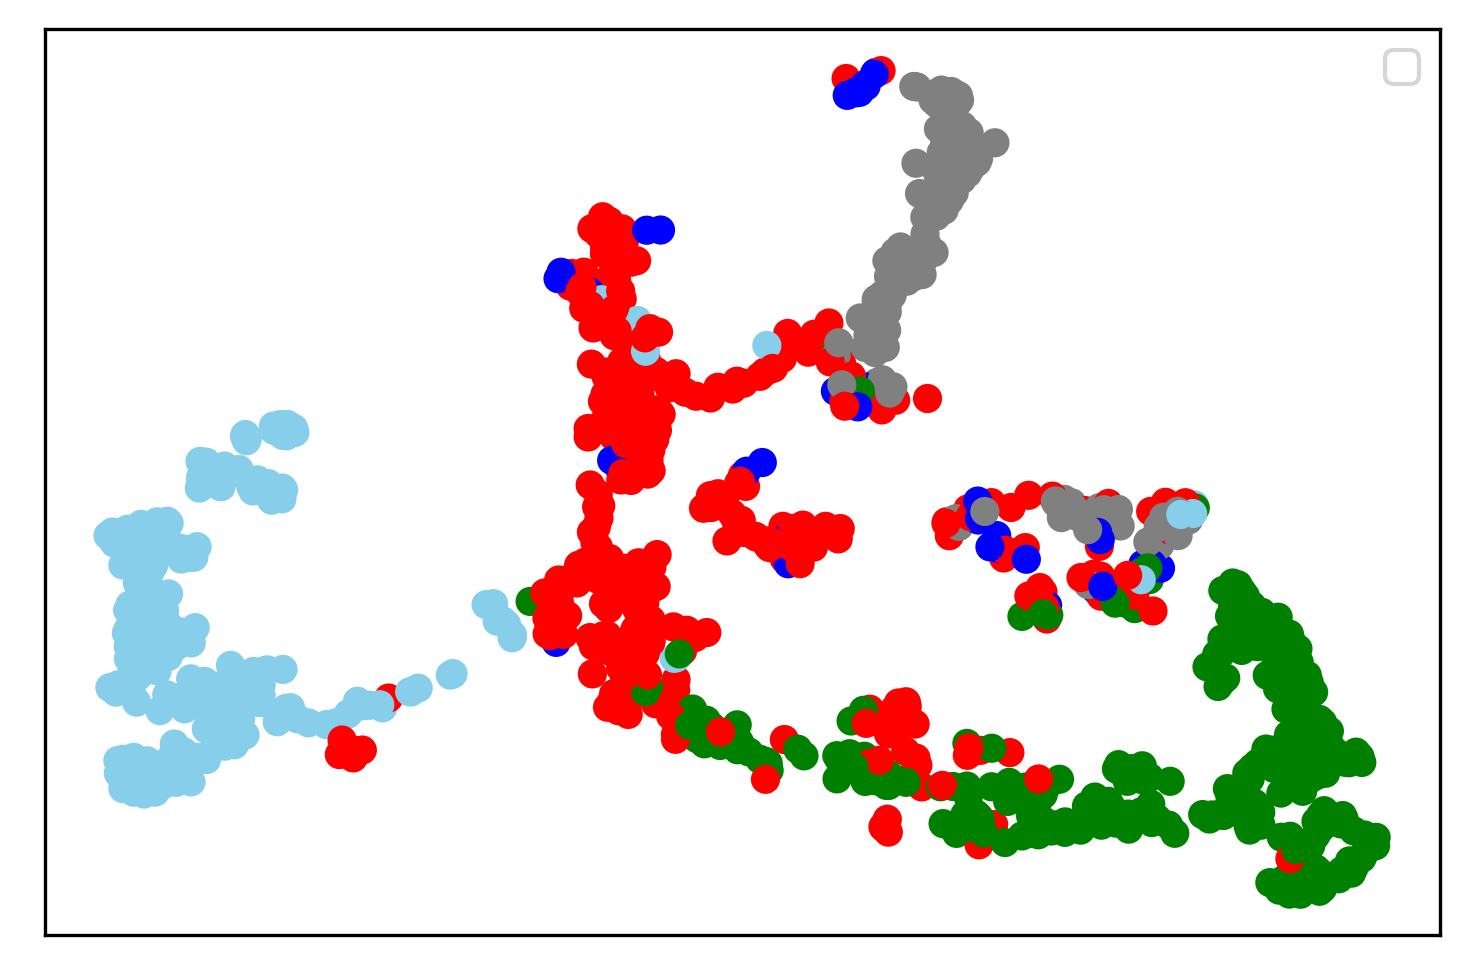

In [108]:
df = pd.DataFrame(dict(X=dot[:,0], Y=dot[:,1],y_hat=y_label.cpu()))

fig, ax = plt.subplots()

colors = {0:'red', 1:'green', 2:'skyblue', 3:'gray', 4:'blue'}

ax.scatter(df['X'], df['Y'], c=df['y_hat'].map(colors))

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.legend()

plt.show()